# Setup/Imports

In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import scipy.stats
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator

from sklearn.metrics import r2_score
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1,
                            allow_soft_placement=True,
                            device_count={'CPU': 1,
                                          'GPU': 0})
session = tf.Session(config=config)
K.set_session(session)


In [3]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

# Analysis

In [4]:
"""THIS IS THE ONE FROM THE PAPER AS OF 3/5"""
file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'

"""This is the one for the paper as of 5/20"""
file_path = '/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5'


file_path = '/projects/EKOLEMEN/profile_predictor/run_results_06_29/model-conv2d_profiles-dens-temp-q_EFIT02-rotation-press_EFIT02_act-target_density-pinj-tinj-curr_target_29Jun20-23-56_Scenario-835.h5'

# base_path = os.path.expanduser('~/run_results_02_13/')
# model_path = 'model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_15Feb20-20-16_Scenario-62.h5'
# file_path = base_path + model_path


model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv2d_profiles-dens-temp-q_EFIT02-rotation-press_EFIT02_act-target_density-pinj-tinj-curr_target_29Jun20-23-56_Scenario-835.h5
loaded dict: model-conv2d_profiles-dens-temp-q_EFIT02-rotation-press_EFIT02_act-target_density-pinj-tinj-curr_target_29Jun20-23-56_Scenario-835_params.pkl
with parameters: dict_keys(['model_type', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'sample_weighting', 'scalar_input_names', 'std_activation', 'batch_size', 'process_data', 'epochs', 'loss_function', 'actuator_names', 'profile_downsample', 'loss_function_kwargs', 'flattop_only', 'predict_deltas', 'raw_data_path', 'invert_q', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'val_idx', 'nshots', 'excluded_shots', 'lookbacks', 'sig_names', '

In [5]:
orig_data_path = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(orig_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      invert_q=scenario.setdefault('invert_q',False),
                                                      val_idx = 0,
                                                      uncertainties=True)
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])
valdata = helpers.normalization.renormalize(helpers.normalization.denormalize(valdata.copy(),normalization_dict),scenario['normalization_dict'])


Loading
Signals: curr_target, dens, pinj, press_EFIT02, q_EFIT02, rotation, target_density, temp, tinj
Number of useable shots:  4862
Number of shots used:  4862
Total number of timesteps:  516083
Shots with Complete NaN: 
351116 samples total


/home/wconlin/plasma-profile-predictor/helpers/data_generator.py:700: RuntimeWarning: divide by zero encountered in true_divide
  alldata[sig] = 1/alldata[sig]


Removing ECH
Removed 151953 samples
199163 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 37903 samples
161260 samples remaining
Removing weird I-coils
Removed 36113 samples
125147 samples remaining
Removing NaN
Removed 0 samples
125147 samples remaining
Removing dudtrip
Removed 6986 samples
118161 samples remaining
118161 samples remaining after pruning


Denormalizing:  67%|######6   | 14/21 [00:00<00:00, 79.97it/s]

Total number of samples:  118161
Number of training samples:  106413
Number of validation samples:  11748


Normalizing: 100%|##########| 21/21 [00:00<00:00, 110.01it/s]


In [6]:
print('num train shots: ',len(np.unique(traindata['shotnum'])))
print('num test shots: ',len(np.unique(valdata['shotnum'])))

num train shots:  2697
num test shots:  302


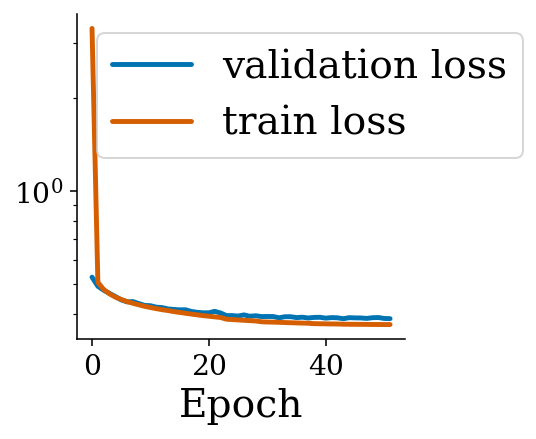

In [7]:
fig, ax = plt.subplots(figsize=(3,3))
ax.semilogy(scenario['history']['val_loss'],label='validation loss')
ax.semilogy(scenario['history']['loss'],label='train loss')
ax.set_xlabel('Epoch', size=20)
ax.legend(fontsize=20)
#plt.ylim(0,.1)
# fig.savefig('training.png')

In [16]:
profiles=scenario['target_profile_names']
psi = np.linspace(0,1,scenario['profile_length'])

In [20]:
profiles

['dens', 'temp', 'rotation']

In [17]:
with open('/projects/EKOLEMEN/profile_predictor/full_pca_fitters.pkl','rb') as f:
    full_pca_fitters = pickle.load(f, encoding='latin1')
with open('/projects/EKOLEMEN/profile_predictor/delta_pca_fitters.pkl','rb') as f:
    delta_pca_fitters = pickle.load(f, encoding='latin1')


In [18]:
delta_pca_fitters.keys()

dict_keys(['temp', 'dens', 'rotation', 'itemp', 'idens', 'press_EFIT01', 'q_EFIT01', 'press_EFIT02', 'q_EFIT02'])

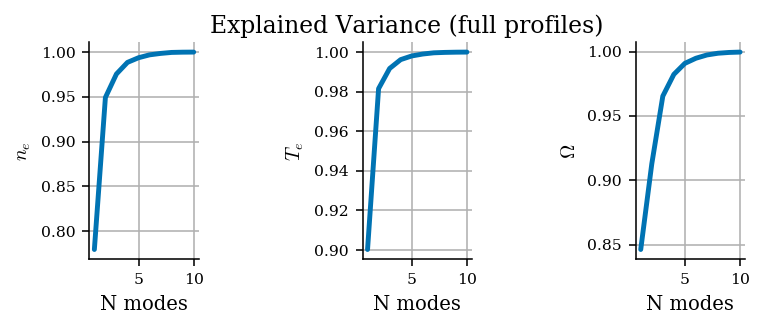

In [19]:
"""plot explained variance"""

ylabels = ['$n_e$','$T_e$','$\Omega$','$\iota$','$P$']

fig, axes = plt.subplots(1,len(profiles),sharey=False,figsize=(6,2))
for j,profile in enumerate(profiles):
    pca=delta_pca_fitters[profile]
    ax = axes[j]
    
    ax.plot(np.arange(1,pca.n_components+1),np.cumsum(pca.explained_variance_ratio_))
    ax.set_ylabel(ylabels[j],size=10)
    ax.set_xlabel('N modes', size=10)
    ax.grid()
    ax.tick_params(axis='both', which='both', labelsize=8)

fig.suptitle('Explained Variance (full profiles)', size=12)
plt.subplots_adjust(wspace=1.5)
# fig.savefig('explained_variance.png')

KeyError: 'q_EFIT02'

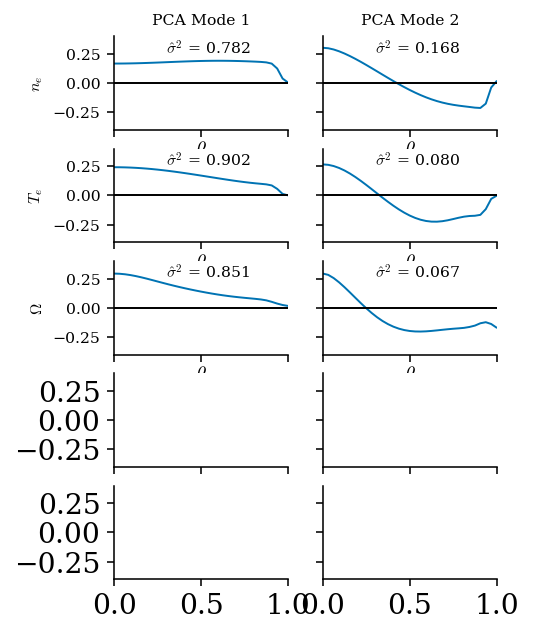

In [12]:
"""plot full pca modes"""

ncols = 2
nrows = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(3.5,5))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))


labels = ['$n_e$','$T_e$','$\Omega$','$\iota$','$P$']
profiles = ['dens','temp','rotation','q_EFIT02','press_EFIT02']
for i,profile in enumerate(profiles):
    pca=delta_pca_fitters[profile]
    for j in range(ncols):
        ax= axes[i,j]
        ax.plot(psi,pca.components_[j],lw=1)
        ax.text(0.3,0.25,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca.explained_variance_ratio_[j]),fontsize=8)
        if j==0:
            ax.set_ylabel(labels[i], size=8)
        if i==0:
            ax.set_title('PCA Mode {}'.format(j+1), size=8)
        if i in [0,1,2]:
            ax.set_xlabel('$\\rho$',size=10)
        if i in [3,4]:
            ax.set_xlabel('$\psi$',size=10)
        ax.set_ylim(-.4,.4)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_xticks([0,.5,1])
        ax.set_xlim(0,1)

        ax.axhline(0,c='k',lw=1)
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
# fig.savefig('images/pca_modes.pdf')
# fig.savefig('images/pca_modes.png')

# Some helper functions

In [19]:
   
def scalarize_mean(arr, **kwargs):
    return np.mean(arr)

def scalarize_std(arr, **kwargs):
    return np.std(arr)

def scalarize_pca_1(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[2]
    return ret

def scalarize_pca_4(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[3]
    return ret

def scalarize_pca_5(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[4]
    return ret

def scalarize_pca_6(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[5]
    return ret

def find_bounds(true,pred,percentile=90):
    arr = np.concatenate([true,pred]).flatten()
  
    true_bounds=(np.percentile(true, 50-percentile/2),np.percentile(true, 50+percentile/2))
    pred_bounds=(np.percentile(pred, 50-percentile/2),np.percentile(pred, 50+percentile/2))
    return (np.maximum(true_bounds[0],pred_bounds[0]),np.minimum(true_bounds[1],pred_bounds[1]))

In [42]:
eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$ ($10^{19}/m^3$)',
          'etemp': '$T_e$ (keV)',
          'itemp': '$T_i$ (keV)',
          'rotation':'$\Omega$ (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}

In [20]:
"""make predictions"""

data_generator_batch = DataGenerator(valdata,
                                128, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                shuffle=False,
                                sample_weights = None) 

predictions_arr = model.predict_generator(data_generator_batch,verbose=1)

104/104 [==============================] - 346s 3s/step


In [27]:
"""get baseline error = predict constant, so just getting the target from the train generator"""

baseline = {sig:[] for sig in scenario['target_profile_names']}
full_profiles = {sig:[] for sig in scenario['target_profile_names']}
for i in range(len(data_generator_batch)):
    print("{}/{}".format(i+1,len(data_generator_batch)),end='\r')
    sample = data_generator_batch[i]
    for sig in scenario['target_profile_names']:
        baseline[sig].append(sample[1]['target_'+sig])
        full_profiles[sig].append(sample[0]['input_'+sig].squeeze() + sample[1]['target_'+sig])


In [28]:
"""reorganize"""

predictions = {sig: arr for sig, arr in zip(scenario['target_profile_names'],predictions_arr)}
baseline = {sig:np.concatenate(baseline[sig],axis=0).squeeze() for sig in scenario['target_profile_names']}
full_profiles = {sig:np.concatenate(full_profiles[sig],axis=0).squeeze() for sig in scenario['target_profile_names']}

In [29]:
"""calculate errors"""

model_err = {sig: np.abs(predictions[sig] - baseline[sig]) for sig in scenario['target_profile_names']}
baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}


In [30]:
"""get median and 25/75 percentile errors, denormalized, for model and baseline"""

hi_per = 75
low_per = 25

med_model_err = {sig:np.median(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_full_profile = {sig:np.median(full_profiles[sig]*scenario['normalization_dict'][sig]['iqr']
                                  + scenario['normalization_dict'][sig]['median'],axis=0) for sig in scenario['target_profile_names']}

hiper_model_err = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
hiper_baseline_err = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
hiper_full_profile = {sig:np.percentile(full_profiles[sig]*scenario['normalization_dict'][sig]['iqr']
                                         + scenario['normalization_dict'][sig]['median'],hi_per,axis=0) for sig in scenario['target_profile_names']}

lowper_model_err = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
lowper_baseline_err = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
lowper_full_profile = {sig:np.percentile(full_profiles[sig]*scenario['normalization_dict'][sig]['iqr']
                                          + scenario['normalization_dict'][sig]['median'],low_per,axis=0) for sig in scenario['target_profile_names']}

In [34]:
"""get PCA coeffs"""

fitter = delta_pca_fitters
scalarize_functions = [scalarize_mean, scalarize_pca_1,scalarize_pca_2]
scalarize_function_names = [fun.__name__[10:] for fun in scalarize_functions]
profiles = scenario['target_profile_names']

num_samples = len(baseline[list(baseline.keys())[0]])

all_true_delta = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}
all_predicted_delta = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}

n=1
nmax = len(profiles)*num_samples*len(scalarize_functions)
for j,profile in enumerate(profiles):
    for k in range(num_samples):
        target = baseline[profile][k][np.newaxis,:]
        pred = predictions[profile][k][np.newaxis,:]
        for i,scalarize in enumerate(scalarize_functions):
            all_true_delta[profile][scalarize_function_names[i]][k] = scalarize(target, fitter=fitter[profile])
            all_predicted_delta[profile][scalarize_function_names[i]][k] = scalarize(pred, fitter=fitter[profile])  
            print('{}/{}'.format(n,nmax),end='\r')
            n += 1


# Plot median error

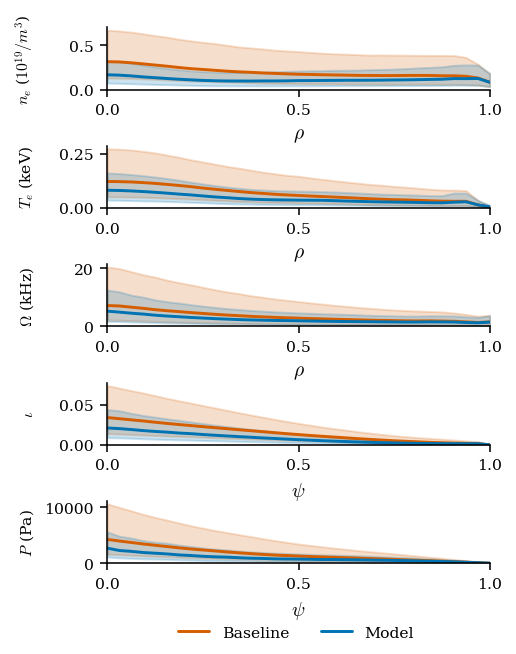

In [39]:
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']


fig, ax = plt.subplots(len(profiles),1,figsize=(3.5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline',lw=1.5)
    ax[i].fill_between(psi,lowper_baseline_err[sig],hiper_baseline_err[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model',lw=1.5)
    ax[i].fill_between(psi,lowper_model_err[sig],hiper_model_err[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[sig],size=8)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=10)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=10)

plt.subplots_adjust(hspace=0.9, bottom=0.12)
fig.align_ylabels(ax)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=8);
# fig.savefig('images/average_error.pdf',bbox_inches='tight',pad_inches=0.1)
# fig.savefig('images/average_error.png',bbox_inches='tight',pad_inches=0.1)

# Scatter plots of PCA coeffs

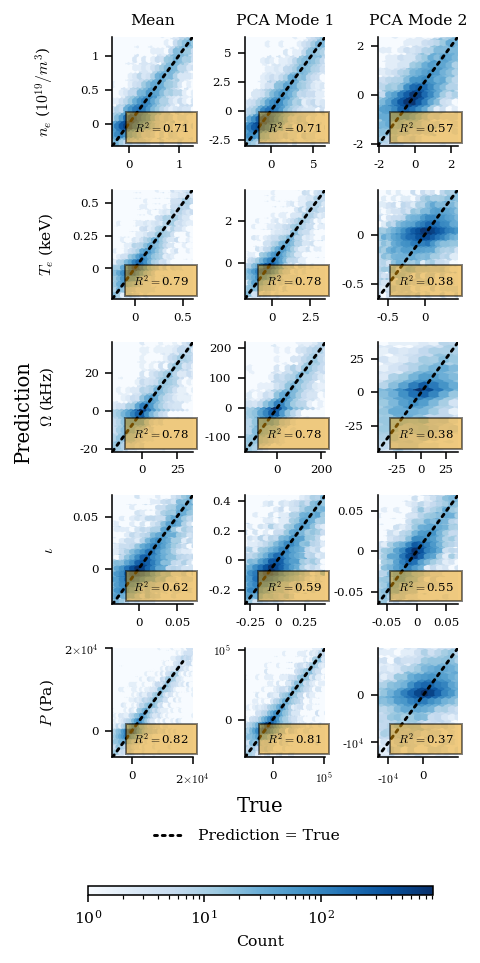

In [75]:
"""Scatter plot of deltas"""


def my_formatter(x, pos):
    if abs(x - int(x))< np.finfo(np.float32).eps:
        return str(int(x))
    else:
        return str(np.around(x,3))
#         if x<0:
#             return str(x)[:6]
#         else:
#             return str(x)[:5]

formatter = matplotlib.ticker.FuncFormatter(my_formatter)

profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']

fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), figsize=(3.5,7))

for i,profile in enumerate(profiles):
    for j,name in enumerate(scalarize_function_names):

        pred=copy.deepcopy(all_predicted_delta[profile][name])
        true=copy.deepcopy(all_true_delta[profile][name])

        ax = axes[i,j]
#         if name in ['Mean','Std. Dev.']:
        pred *= scenario['normalization_dict'][profile]['iqr']
        true *= scenario['normalization_dict'][profile]['iqr']
        
        bounds = find_bounds(true,pred,95)
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)

        r2_model = r2_score(true,pred)
        r2_baseline = r2_score(true, np.zeros(true.shape))

        hb = ax.hexbin(true,pred,gridsize=100,bins='log',mincnt=0,cmap='Blues')
        ax.text(0.95, 0.1, '$R^2=${:.2f}'.format(r2_model), fontsize=6, horizontalalignment='right',verticalalignment='bottom', 
                transform=ax.transAxes,bbox=dict(facecolor=colorblind_colors[-1], alpha=0.5))
#         ax.text(0.95, 0.1, '$R^2=${:.2f}'.format(r2_baseline), fontsize=8, horizontalalignment='right',verticalalignment='bottom', 
#                 transform=ax.transAxes,bbox=dict(facecolor=colorblind_colors[1], alpha=0.5)) 

        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color='k', linestyle=':',lw=1.5,label='Prediction = True')
#         ax.axhline(0,color=colorblind_colors[1],lw=1.5,label='Baseline')
        if i==0:
            ax.set_title(scatter_titles[name], size=8)
#         if i==len(profiles)-1:
#             ax.set_xlabel('True',size=10)
        if j in [0]:
            ax.set_ylabel(labels[profile], size=8)
#         if j in [1,2,3]:
#             if ylabels[i] == '$q$':
#                 ax.set_ylabel(labels[i] + ' \n Prediction', size=10)
#             else:
#                 ax.set_ylabel(labels[i] + ' (unitless) \n Prediction', size=10)
        ax.tick_params(axis='both', which='major', labelsize=6)
#         ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        ax.xaxis.set_minor_formatter(formatter)
        ax.yaxis.set_minor_formatter(formatter)

# axes[3,1].set_xticks([-.25,0,.25])
# axes[3,1].set_xticklabels(['-0.25','0','0.25'])
# axes[3,2].set_xticks([-.25,0,.25])
# axes[3,2].set_xticklabels(['-0.25','0','0.25'])

axes[4,0].set_yticks([0,20000])
axes[4,0].set_yticklabels(['0',r'2$\times 10^4$'])
axes[4,0].set_xticks([0,20000])
axes[4,0].set_xticklabels(['0',r'2$\times 10^4$'])

axes[4,1].set_yticks([0,100000])
axes[4,1].set_yticklabels(['0',r'$10^5$'])
axes[4,1].set_xticks([0,100000])
axes[4,1].set_xticklabels(['0',r'$10^5$'])

axes[4,2].set_yticks([0,-10000])
axes[4,2].set_yticklabels(['0',r'-$10^4$'])
axes[4,2].set_xticks([0,-10000])
axes[4,2].set_xticklabels(['0',r'-$10^4$'])

plt.subplots_adjust(hspace=0.4,wspace=0.65,bottom=0.15, left=0.2)

fig.text(0.5, 0.1, 'True', va='center', ha='center', fontsize=10)
fig.text(0.02, 0.5, 'Prediction', va='center', ha='center', rotation='vertical', fontsize=10)

fig.align_ylabels(axes[:,0])



cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.01])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal', fraction=.3)
cb.set_label('Count', size=8)
cb.ax.tick_params(labelsize=8)

fig.legend(handles=axes[0,0].lines,     
           labels=[line._label for line in axes[0,0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.5, 0.15),
           frameon=False,
           mode=None,
           ncol=2,
           fontsize=8);
fig.savefig('images/all_pca_acc.pdf',bbox_inches='tight',pad_inches=0.1)
fig.savefig('images/all_pca_acc.png',bbox_inches='tight',pad_inches=0.1)

# Timeslice

In [76]:
data_generator = DataGenerator(valdata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                shuffle=False,
                                sample_weights = None)

12951


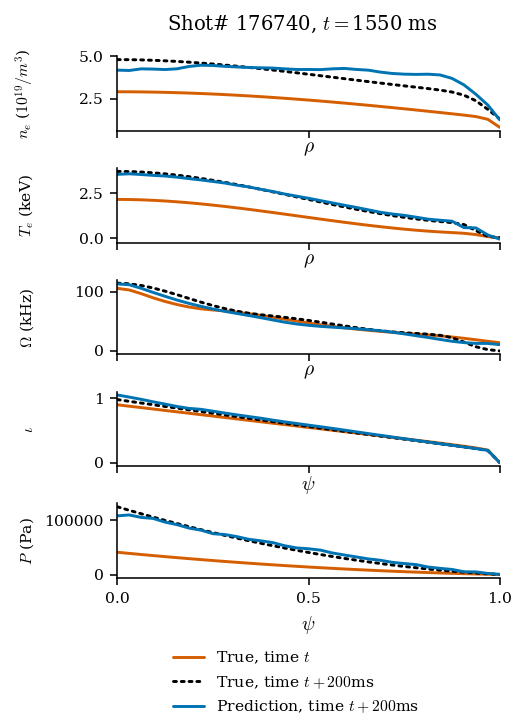

In [165]:
good_indices = [5085,8351,1749,10746,7299,479,9980,5878,1297,12951]

index = np.random.randint(len(data_generator))
index = good_indices[9]
print(index)
inputs, targets,_ = data_generator[index]
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']

shotnum = data_generator.cur_shotnum[0,0]
shottime = data_generator.cur_times[0,-scenario['lookahead']-1]

predictions= model.predict_on_batch(inputs)
predictions = {sig: pred for sig, pred in zip(scenario['target_profile_names'],predictions)}

fig, axes = plt.subplots(len(profiles),1,sharex=True, figsize=(3.5,5))
for j, profile in enumerate(profiles):
    ax = axes[j]
    inp = inputs['input_{}'.format(profile)].squeeze()
    true = inputs['input_{}'.format(profile)].squeeze() + targets['target_{}'.format(profile)].squeeze()
    pred = inputs['input_{}'.format(profile)].squeeze() + predictions[profile].squeeze()

    inp = helpers.normalization.denormalize_arr(inp,scenario['normalization_dict'][profile])
    true = helpers.normalization.denormalize_arr(true,scenario['normalization_dict'][profile])
    pred = helpers.normalization.denormalize_arr(pred,scenario['normalization_dict'][profile])

    ax.plot(psi,inp,lw=1.5,label='True, time $t$',c=colorblind_colors[1])
    ax.plot(psi,true,lw=1.5,label='True, time $t+200$ms',c='k',ls=':')
    ax.plot(psi,pred,lw=1.5,label='Prediction, time $t+200$ms',c=colorblind_colors[0])

    ax.set_ylabel(labels[profile],size=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xticks([0,.5,1])
    ax.set_xlim(0,1)
    if j in [0,1,2]:
        ax.set_xlabel('$\\rho$',size=10)
    if j in [3,4]:
        ax.set_xlabel('$\psi$',size=10)
fig.align_ylabels(axes)
plt.subplots_adjust(top=.92, bottom=.18, hspace=0.5)
fig.suptitle("Shot# {}, $t=${} ms".format(int(shotnum), int(shottime)),fontsize=10)
fig.legend(handles=axes[0].lines,     
           labels=[line._label for line in axes[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.12),
           frameon=False,
           mode=None,
           ncol=1,
          fontsize=8)
fig.savefig('images/timeslice_{}.png'.format(index),bbox_inches='tight',pad_inches=0.1)
fig.savefig('images/timeslice_{}.pdf'.format(index),bbox_inches='tight',pad_inches=0.1)

# Phase space scatter plot

In [166]:
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl' 
with open(test_data_path,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')

In [173]:
shots = list(rawdata.keys())
nshots = len(shots)

In [192]:
def stats_1d(x):
    y = (np.nanmean(x), np.nanstd(x))
    if all(np.isfinite(y)):
        return y
    else:
        return (np.nan,np.nan)

def stats_2d(x):
    y = np.nanmean(x,axis=1)
    z = (np.nanmean(y), np.nanstd(y))
    if all(np.isfinite(z)):
        return z
    else:
        return (np.nan,np.nan)


In [196]:
sigs1d = ['pinj','tinj','target_density','gasA','curr_target']
sigs2d = ['temp','dens','rotation']
sigs = sigs1d + sigs2d
data = {sig:{'mean':np.zeros(nshots),'std':np.full(nshots,np.nan)} for sig in sigs}

for i, shot in enumerate(shots):
    if set(sigs).issubset(set(rawdata[shot].keys())):
        for sig in sigs:
            if sig in sigs1d:
                data[sig]['mean'][i], data[sig]['std'][i] = stats_1d(rawdata[shot][sig])
            elif sig in sigs2d:
                data[sig]['mean'][i], data[sig]['std'][i] = stats_2d(rawdata[shot][sig])    

/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


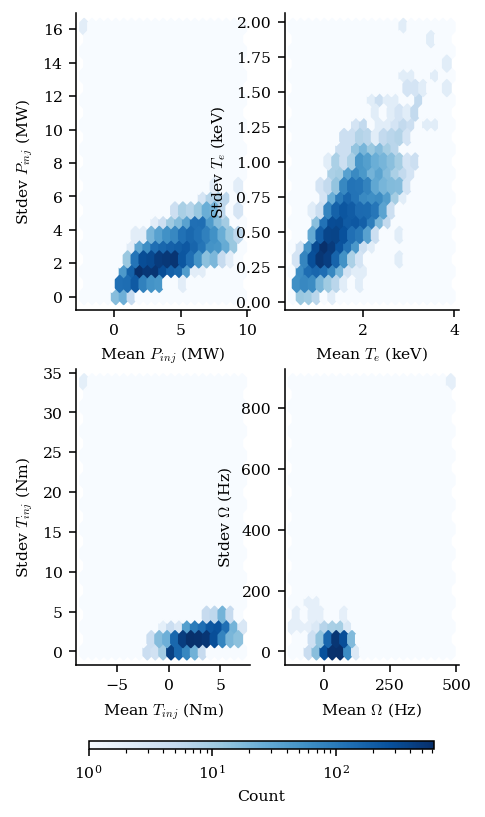

In [211]:
sig = 'temp'
fig, axes = plt.subplots(2,2,figsize=(3.5,6))

hb = axes[0,0].hexbin(data['pinj']['mean']/1000,data['pinj']['std']/1000,cmap='Blues',bins='log',mincnt=0,gridsize=20)
axes[0,0].tick_params(axis='both', which='major', labelsize=8)
axes[0,0].set_xlabel('Mean $P_{inj}$ (MW)', fontsize=8)
axes[0,0].set_ylabel('Stdev $P_{inj}$ (MW)', fontsize=8)


axes[0,1].hexbin(data['temp']['mean'],data['temp']['std'],cmap='Blues',bins='log',mincnt=0,gridsize=20)
axes[0,1].tick_params(axis='both', which='major', labelsize=8)
axes[0,1].set_xlabel('Mean $T_{e}$ (keV)', fontsize=8)
axes[0,1].set_ylabel('Stdev $T_{e}$ (keV)', fontsize=8)

axes[1,0].hexbin(data['tinj']['mean'],data['tinj']['std'],cmap='Blues',bins='log',mincnt=0,gridsize=20)
axes[1,0].tick_params(axis='both', which='major', labelsize=8)
axes[1,0].set_xlabel('Mean $T_{inj}$ (Nm)', fontsize=8)
axes[1,0].set_ylabel('Stdev $T_{inj}$ (Nm)', fontsize=8)

axes[1,1].hexbin(data['rotation']['mean'],data['rotation']['std'],cmap='Blues',bins='log',mincnt=0,gridsize=20)
axes[1,1].tick_params(axis='both', which='major', labelsize=8)
axes[1,1].set_xlabel('Mean $\Omega$ (Hz)', fontsize=8)
axes[1,1].set_ylabel('Stdev $\Omega$ (Hz)', fontsize=8)

cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.01])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal', fraction=.3)
cb.set_label('Count', size=8)
cb.ax.tick_params(labelsize=8)

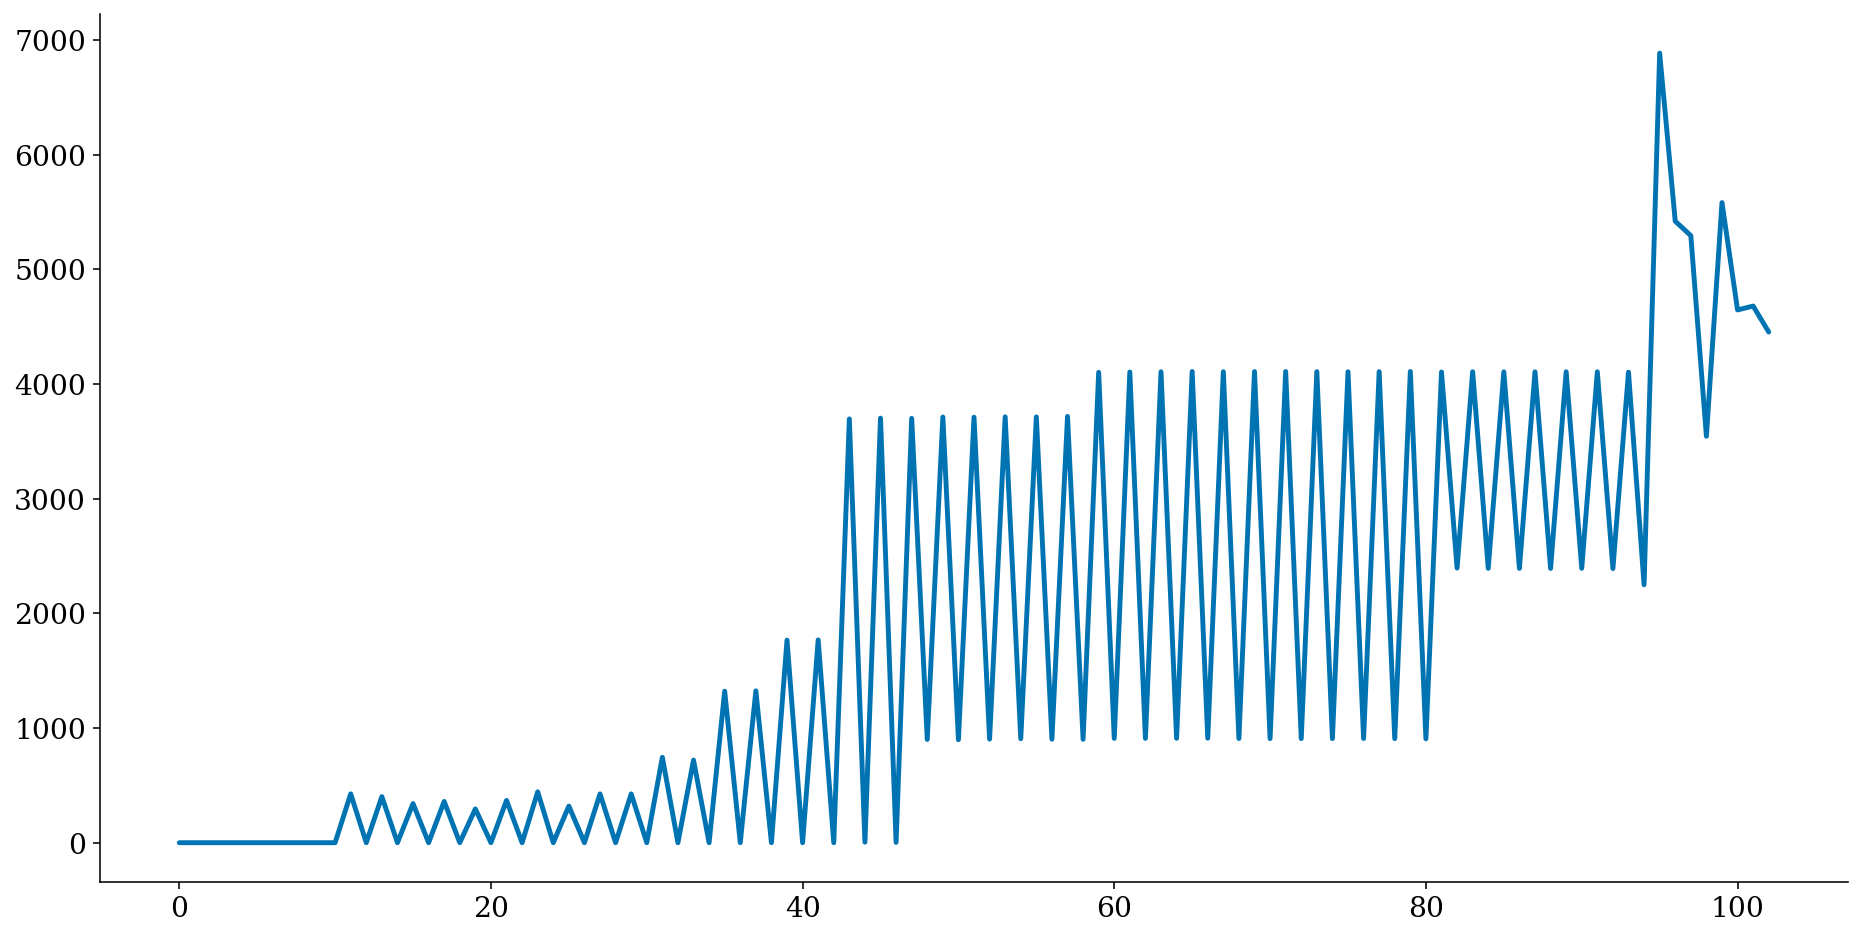

In [212]:
shot = shots[100]

plt.plot(rawdata[shot]['pinj'])